# Convolutional Auto-Encoders from the Ground-up

In [1]:
import numpy as np  # required for most computation
import matplotlib.pyplot as plt # for generating visuals
from sklearn.model_selection import train_test_split # Used to make the dataset split


# tensorflow libs
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
from tensorflow.keras import layers, models



Load in the data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Split the training data into training (80%) and validation (10%)
x_train, val_images, y_train, val_labels = train_test_split(
    x_train, y_train, test_size=0.1111
)  # 0.1111 gives approximately a 10% validation split

# Check the shapes of the splits
print("Training data shape:", x_train.shape, y_train.shape)
print("Validation data shape:", val_images.shape, val_labels.shape)
print("Testing data shape:", x_test.shape, x_test.shape)


Training data shape: (44445, 32, 32, 3) (44445, 1)
Validation data shape: (5555, 32, 32, 3) (5555, 1)
Testing data shape: (10000, 32, 32, 3) (10000, 32, 32, 3)


## Model initialization

![Screenshot 2024-11-08 at 08-53-31 Lab_CAE.pdf.png](<attachment:Screenshot 2024-11-08 at 08-53-31 Lab_CAE.pdf.png>)
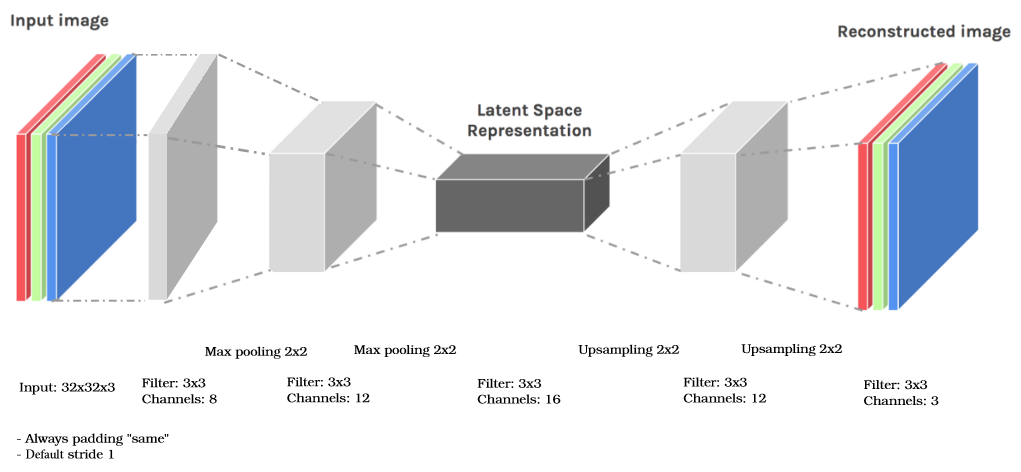

In [9]:
class ConvolutionalAutoencoder:
    def __init__(self, input_shape=(32, 32, 3)):
        self.input_shape = input_shape
        self.model = self.build_autoencoder()
    
    def build_encoder(self, encoder_input):
        # Encoder architecture
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=1)(encoder_input)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Downsample to 16x16x8

        x = layers.Conv2D(12, (3, 3), activation='relu', padding='same', strides=1)(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Downsample to 8x8x12

        x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(x)
        latent_space = layers.MaxPooling2D((2, 2), padding='same')(x)  # Latent space of size 4x4x16

        return latent_space

    def build_decoder(self, latent_space):
        # Decoder architecture
        x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(latent_space)
        x = layers.UpSampling2D((2, 2))(x)  # Upsample to 8x8x16

        x = layers.Conv2D(12, (3, 3), activation='relu', padding='same', strides=1)(x)
        x = layers.UpSampling2D((2, 2))(x)  # Upsample to 16x16x12

        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=1)(x)
        x = layers.UpSampling2D((2, 2))(x)  # Upsample to 32x32x8

        decoder_output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', strides=1)(x)  # Output shape 32x32x3
        return decoder_output

    def build_autoencoder(self):
        # Input layer
        encoder_input = layers.Input(shape=self.input_shape)
        
        # Build encoder and decoder
        latent_space = self.build_encoder(encoder_input)
        decoder_output = self.build_decoder(latent_space)
        
        # Combine encoder and decoder into the autoencoder model
        autoencoder = models.Model(inputs=encoder_input, outputs=decoder_output)
        
        # Compile the model
        autoencoder.compile(optimizer='adam', loss='mse')
        
        return autoencoder
    
    def summary(self):
        return self.model.summary()

    def train(self, x_train, epochs=10, batch_size=32, validation_data=None):
        history = self.model.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
        return self.model, history

    def encode(self, x):
        # Adjust this to use the correct latent space layer output
        encoder_model = models.Model(inputs=self.model.input, outputs=self.model.get_layer(index=-7).output)  # Adjust the layer index as needed
        return encoder_model.predict(x)

    def decode(self, latent_representation):
        # Extract decoder part for decoding latent representations with dynamic shape
        latent_dim = latent_representation.shape[1:]
        decoder_input = layers.Input(shape=latent_dim)  # Use dynamic shape for flexibility
        decoder_output = self.build_decoder(decoder_input)
        decoder_model = models.Model(inputs=decoder_input, outputs=decoder_output)
        return decoder_model.predict(latent_representation)


Epoch 1/5
695/695 [==============================] - 51s 71ms/step - loss: 0.0230 - val_loss: 0.0152
Epoch 2/5
695/695 [==============================] - 49s 70ms/step - loss: 0.0142 - val_loss: 0.0133
Epoch 3/5
695/695 [==============================] - 53s 76ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 4/5
695/695 [==============================] - 49s 71ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 5/5
313/313 [==============================] - 1s 2ms/step


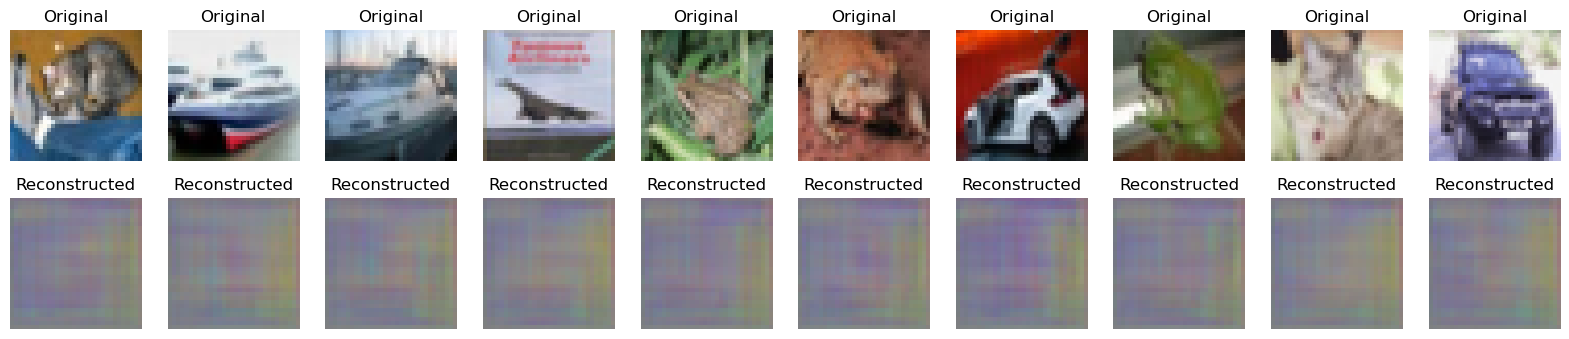

In [ ]:

autoencoder = ConvolutionalAutoencoder(input_shape=(32, 32, 3))

# autoencoder.summary()

# Train the autoencoder
model, history = autoencoder.train(
    x_train, 
    epochs=5, 
    batch_size=64, 
    validation_data=(val_images, val_images)
)

model.save("autoencoder_model.h5")

313/313 [==============================] - 1s 3ms/step


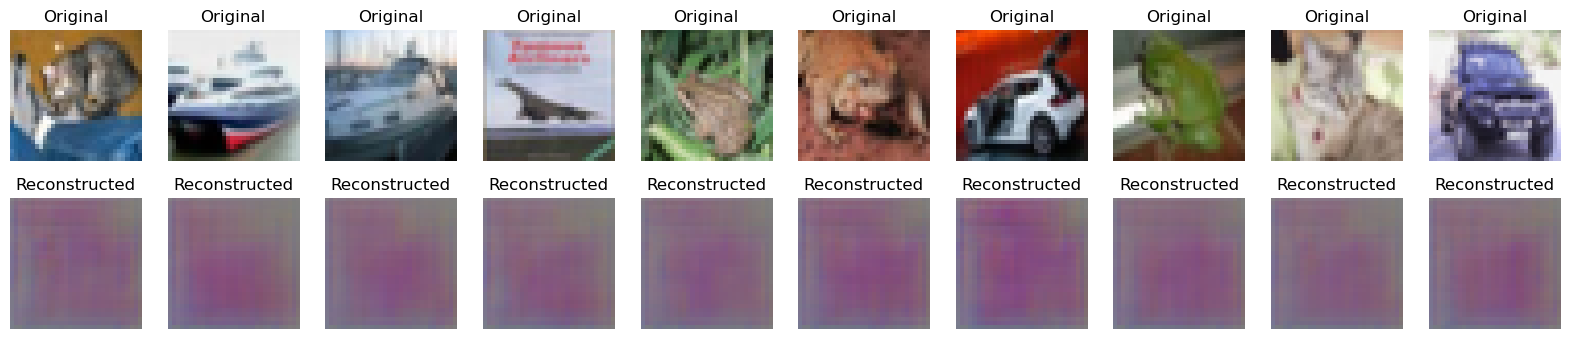

In [17]:
autoencoder = ConvolutionalAutoencoder(input_shape=(32, 32, 3))
autoencoder.model = models.load_model("autoencoder_model.h5")
# Encoding and decoding some images from the test set
encoded_imgs = autoencoder.encode(x_test)
decoded_imgs = autoencoder.decode(encoded_imgs)

n = 10  # Display 10 images
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    # Display reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()